In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [2]:
nielsen15 = pd.read_csv('../../Nielsen/aggregated_nielsen_2015.csv')
nielsen16 = pd.read_csv('../..//Nielsen/aggregated_nielsen_2016.csv')
nielsen15['year'] = 2015
nielsen16['year'] = 2016

In [3]:
nielsen = pd.concat((nielsen15, nielsen16))
nielsen = nielsen[~nielsen.is_walmart]

In [4]:
## Entriy/exit dates
fandom = pd.read_csv('../data_collection/plein_de_data/fandom_traitées.csv', parse_dates=['Opening_date', 'Closing_date'])[['State', 'County_name', 'County_fips', 'Opening_date', 'Closing_date']]

# We drop the state in which we do not trust our data (some mistakes stillremain)
fandom = fandom[~np.isin(fandom.State, ('CA', 'GA', 'KS', 'LA', 'TX'))]
nielsen = nielsen[~np.isin(nielsen.store_state, ('CA', 'GA', 'KS', 'LA', 'TX'))]

# We concentrate our study on the movements (entries & exits) during the fiscal years 2015 and 2016
movements = fandom[((fandom.Opening_date >= '2015-01-31') & (fandom.Opening_date <= '2017-01-31')) | ((fandom.Closing_date >= '2015-01-31') & (fandom.Closing_date <= '2017-01-31'))]
#movements['year'] = movements.Opening_date.dt.year
#movements['month'] = movements.Opening_date.dt.month

In [68]:
nielsen.groupby('product_group_descr').count().sort_values('upc_price', ascending=False).head(20)

,is_walmart,store_state,guessed_store_county,guessed_store_county_fips,purchase_year,purchase_month,upc_price,upc_price_std,nb_of_obs,year
product_group_descr,,,,,,,,,,
FRESH PRODUCE,42329,42329,42329,42329,42329,42329,42329,40500,42329,42329
BREAD AND BAKED GOODS,41725,41725,41725,41725,41725,41725,41725,38980,41725,41725
MILK,40079,40079,40079,40079,40079,40079,40079,36097,40079,40079
SNACKS,39978,39978,39978,39978,39978,39978,39978,36697,39978,39978
PACKAGED MEATS-DELI,39929,39929,39929,39929,39929,39929,39929,36608,39929,39929
CHEESE,39595,39595,39595,39595,39595,39595,39595,36234,39595,39595
UNPREP MEAT/POULTRY/SEAFOOD-FRZN,39240,39240,39240,39240,39240,39240,39240,36505,39240,39240
CARBONATED BEVERAGES,37764,37764,37764,37764,37764,37764,37764,33777,37764,37764
"CONDIMENTS, GRAVIES, AND SAUCES",37701,37701,37701,37701,37701,37701,37701,33389,37701,37701


## FRESH PRODUCE

## THIRD MODEL : adding entity effects

In [86]:
# We choose to focus on fresh produce
product_group = nielsen[nielsen.product_group_descr == 'PACKAGED MEATS-DELI']


# The control group is composed by all states where nothing (no entry nor exit) happened.
control = product_group[~np.isin(product_group.guessed_store_county_fips, movements)].copy()
print(f"Size of the control group: {len(control.guessed_store_county_fips.unique())}.")


# The treatment group is composed by the states where one entry took place in 2016 and where this entry is the only movement
count = movements.groupby('County_fips').count()
count = count[count.Opening_date + count.Closing_date == 1] # No more than one movement in the treatement group
treatment_movements = movements[(np.isin(movements.County_fips, count.index))]

treatment = product_group[np.isin(product_group.guessed_store_county_fips, treatment_movements.County_fips )].copy()
treatment = treatment.merge(treatment_movements, left_on='guessed_store_county_fips', right_on='County_fips')
print(f"Size of the treatment group: {len(treatment.guessed_store_county_fips.unique())}.")


# We create our dummies for the regression
control['treat'] = False
control['interaction'] = 0
control['time_fixed_effects'] = list(zip(control.purchase_month, control.purchase_year))

treatment['treat'] = True
treatment['purchase_0'] = treatment.purchase_month * (treatment.purchase_year == 2015) + (treatment.purchase_month +12) * (treatment.purchase_year == 2016)
treatment['opening_0'] = treatment.Opening_date.dt.month * (treatment.Opening_date.dt.year == 2015) + (treatment.Opening_date.dt.month +12) * (treatment.Opening_date.dt.year == 2016)
treatment['interaction'] = treatment.purchase_0 - treatment.opening_0
treatment = treatment[abs(treatment.interaction) <=7]
treatment['time_fixed_effects'] = list(zip(treatment.purchase_month, treatment.purchase_year))


# Final dataset for the regression :

df = pd.concat((control, treatment))[['upc_price', 'treat', 'interaction', 'time_fixed_effects', 'store_state']]
df = df[df.upc_price != 0]

Size of the control group: 1816.
Size of the treatment group: 89.


In [87]:
wm15 = pd.read_csv('../../Nielsen/aggregated_nielsen_2015.csv')
wm16 = pd.read_csv('../..//Nielsen/aggregated_nielsen_2016.csv')
wm15['year'] = 2015
wm16['year'] = 2016
wm = pd.concat((wm15, wm16))
wm = wm[wm.is_walmart]


## Entriy/exit dates
fandom = pd.read_csv('../data_collection/plein_de_data/fandom_traitées.csv', parse_dates=['Opening_date', 'Closing_date'])[['State', 'County_name', 'County_fips', 'Opening_date', 'Closing_date']]

# We drop the state in which we do not trust our data (some mistakes still remain)
fandom = fandom[~np.isin(fandom.State, ('CA', 'GA', 'KS', 'LA', 'TX'))]
wm = wm[~np.isin(wm.store_state, ('CA', 'GA', 'KS', 'LA', 'TX'))]

In [88]:
# We concentrate our study on the movements (entries & exits) during the fiscal years 2015 and 2016
movements = fandom[((fandom.Opening_date >= '2015-01-31') & (fandom.Opening_date <= '2017-01-31')) | ((fandom.Closing_date >= '2015-01-31') & (fandom.Closing_date <= '2017-01-31'))]


# We choose to focus on milk prices
product_groupwm = wm[wm.product_group_descr == 'PACKAGED MEATS-DELI']

# The control group is composed by all states where nothing (no entry nor exit) happened.
controlwm = product_groupwm[~np.isin(product_groupwm.guessed_store_county_fips, movements)].copy()
print(f"Size of the control group: {len(control.guessed_store_county_fips.unique())}.")

# The treatment group is composed by the states where one entry took place in 2016 and where this entry is the only movement
count = movements.groupby('County_fips').count()
count = count[count.Opening_date + count.Closing_date == 1] # No more than one movement in the treatement group
treatment_movements = movements[(np.isin(movements.County_fips, count.index))]

treatmentwm = product_groupwm[np.isin(product_groupwm.guessed_store_county_fips, treatment_movements.County_fips )].copy()
treatmentwm = treatmentwm.merge(treatment_movements, left_on='guessed_store_county_fips', right_on='County_fips')
print(f"Size of the treatment group: {len(treatmentwm.guessed_store_county_fips.unique())}.")

treatmentwm['treat'] = True
treatmentwm['purchase_0'] = treatmentwm.purchase_month * (treatmentwm.purchase_year == 2015) + (treatmentwm.purchase_month + 12) * (treatmentwm.purchase_year == 2016)
treatmentwm['opening_0'] = treatmentwm.Opening_date.dt.month * (treatmentwm.Opening_date.dt.year == 2015) + (treatmentwm.Opening_date.dt.month + 12) * (treatmentwm.Opening_date.dt.year == 2016)
treatmentwm['interaction'] = treatmentwm.purchase_0 - treatmentwm.opening_0
treatmentwm = treatmentwm[abs(treatmentwm.interaction) <=7]
treatmentwm['time_fixed_effects'] = list(zip(treatmentwm.purchase_month, treatmentwm.purchase_year))

dfwm = pd.concat((controlwm, treatmentwm))[['upc_price', 'treat', 'interaction', 'time_fixed_effects', 'store_state']]
dfwm = dfwm[dfwm.upc_price != 0]

Size of the control group: 1816.
Size of the treatment group: 82.


In [89]:
huhu = treatmentwm.loc[treatmentwm.index.repeat(treatmentwm.nb_of_obs)].reset_index(drop=True).drop('nb_of_obs', axis=1).groupby('interaction').mean()
hihi = treatment.loc[treatment.index.repeat(treatment.nb_of_obs)].reset_index(drop=True).drop('nb_of_obs', axis=1).groupby('interaction').mean()

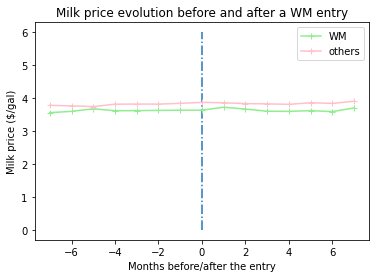

In [90]:
plt.plot(huhu.index, huhu.upc_price, '-+', color='lightgreen', label='WM')
plt.plot(hihi.index, hihi.upc_price, '-+', color='pink', label='others')
plt.title('Milk price evolution before and after a WM entry')
plt.legend()
plt.xlabel('Months before/after the entry')
plt.ylabel('Milk price ($/gal)')
#plt.ylim((0,6))
plt.vlines(0, 0, 6, linestyles='-.');

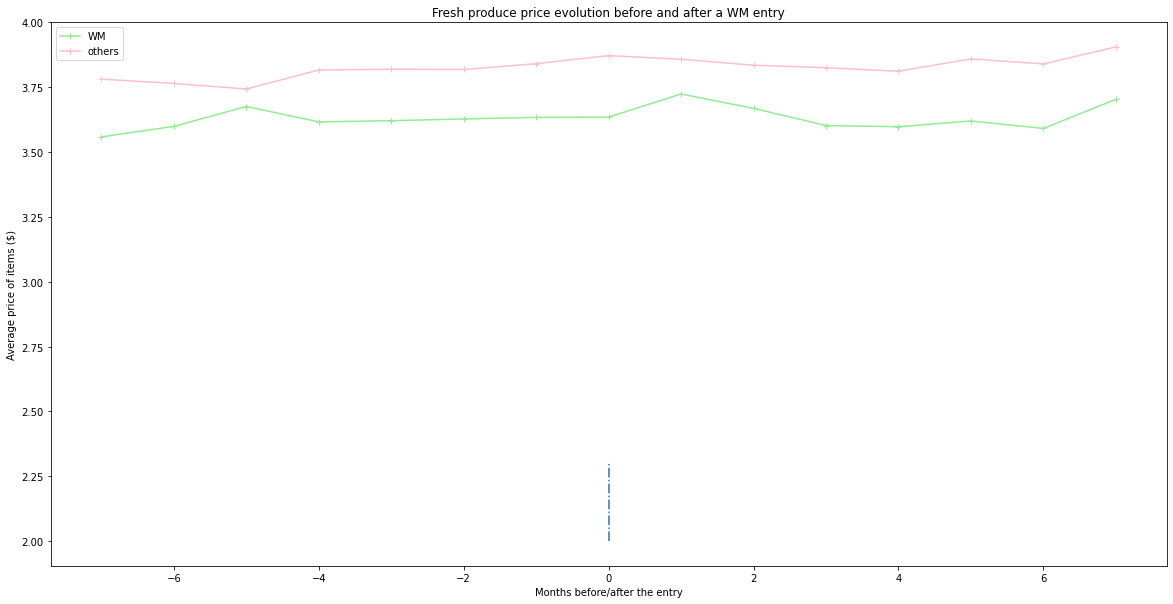

In [91]:
plt.figure(figsize=(20,10))
#plt.plot(hohowm.index, hohowm.upc_price, '-+', color='green', label='WM')
plt.plot(huhu.index, huhu.upc_price, '-+', color='lightgreen', label='WM')
#plt.plot(hoho.index, hoho.upc_price, '-+', color='red', label='others')
plt.title('Fresh produce price evolution before and after a WM entry')
plt.plot(hihi.index, hihi.upc_price, '-+', color='pink', label='others')
plt.legend()
plt.xlabel('Months before/after the entry')
plt.ylabel('Average price of items ($)')
plt.vlines(0, 2, 2.3, linestyles='-.');

Regression model :
$$ Price_{i, t} = \alpha + \beta \cdot treat_i + \delta \cdot treat_i \cdot post_{t} + \sum_{\tau=Janv15}^{Dec16}\gamma_{\tau} \cdot \mathbb{1}(t=\tau) + \sum_{s \in USStates}\gamma_{s} \cdot \mathbb{1}(state = s) + \varepsilon_{i, t}$$

In [101]:
reg0 = smf.ols(
    formula='np.log(upc_price) ~ treat + C(interaction)',
    data=df)
results0 = reg0.fit()

reg1 = smf.ols(
    formula='np.log(upc_price) ~ treat + C(interaction) + C(time_fixed_effects)',
    data=df)
results1 = reg1.fit()

reg2 = smf.ols(
    formula='np.log(upc_price) ~ treat + C(interaction) + C(time_fixed_effects) + C(store_state) + C(time_fixed_effects)*C(store_state)',
    data=df)
results2 = reg2.fit()



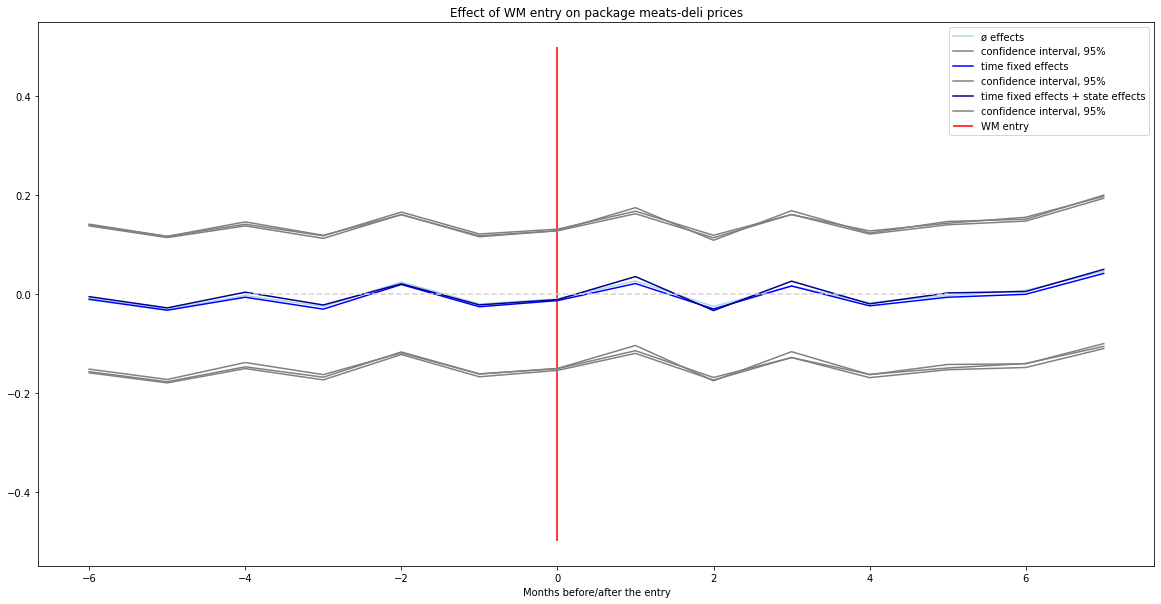

In [102]:
import scipy.stats as stats

plt.figure(figsize=(20, 10))
plt.title('Effect of WM entry on package meats-deli prices')
plt.xlabel('Months before/after the entry')


coefs0 = np.exp(results0.params[2:16]) - 1
cv_t = stats.t.ppf(1 - 0.005, len(df) - len(coefs0) - 2)
lower_CI_5_0 = coefs0 - cv_t * results0.bse[2:16]
upper_CI_5_0 = coefs0 + cv_t * results0.bse[2:16]
plt.plot(range(-6, 8), coefs0, color='lightblue', label='ø effects')
plt.plot(range(-6, 8), lower_CI_5_0, color='grey', label='confidence interval, 95%')
plt.plot(range(-6, 8), upper_CI_5_0, color='grey')

coefs1 = np.exp(results1.params[2:16]) - 1
cv_t = stats.t.ppf(1 - 0.005, len(df) - len(coefs1) - 2)
lower_CI_5_1 = coefs1 - cv_t * results1.bse[2:16]
upper_CI_5_1 = coefs1 + cv_t * results1.bse[2:16]
plt.plot(range(-6, 8), coefs1, color='blue', label='time fixed effects')
plt.plot(range(-6, 8), lower_CI_5_1, color='grey', label='confidence interval, 95%')
plt.plot(range(-6, 8), upper_CI_5_1, color='grey')

coefs2 = np.exp(results2.params[2:16]) - 1
cv_t = stats.t.ppf(1 - 0.005, len(df) - len(coefs2) - 2)
lower_CI_5_2 = coefs2 - cv_t * results2.bse[2:16]
upper_CI_5_2 = coefs2 + cv_t * results2.bse[2:16]
plt.plot(range(-6, 8), coefs2, color='darkblue', label='time fixed effects + state effects' )
plt.plot(range(-6, 8), lower_CI_5_2, color='grey', label='confidence interval, 95%')
plt.plot(range(-6, 8), upper_CI_5_2, color='grey')


plt.plot([-4, 5], [0, 0], linestyle='--', color='lightgrey')
plt.vlines(0, -0.5, 0.5, color='red', label='WM entry')
plt.legend();

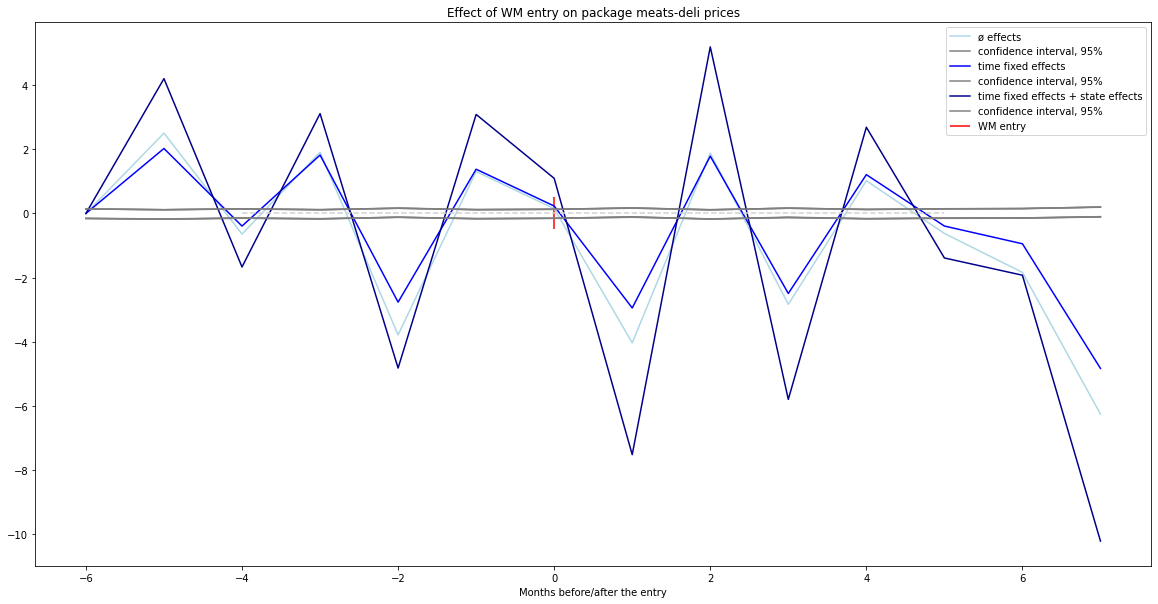

In [105]:
import scipy.stats as stats

plt.figure(figsize=(20, 10))
plt.title('Effect of WM entry on package meats-deli prices')
plt.xlabel('Months before/after the entry')


coefs0 = np.exp(results0.params[2:16]) - 1
cv_t = stats.t.ppf(1 - 0.005, len(df) - len(coefs0) - 2)
lower_CI_5_0 = coefs0 - cv_t * results0.bse[2:16]
upper_CI_5_0 = coefs0 + cv_t * results0.bse[2:16]
plt.plot(range(-6, 8), (coefs0 - coefs0[0]) / coefs0[0], color='lightblue', label='ø effects')
plt.plot(range(-6, 8), lower_CI_5_0, color='grey', label='confidence interval, 95%')
plt.plot(range(-6, 8), upper_CI_5_0, color='grey')

coefs1 = np.exp(results1.params[2:16]) - 1
cv_t = stats.t.ppf(1 - 0.005, len(df) - len(coefs1) - 2)
lower_CI_5_1 = coefs1 - cv_t * results1.bse[2:16]
upper_CI_5_1 = coefs1 + cv_t * results1.bse[2:16]
plt.plot(range(-6, 8), (coefs1 - coefs1[0]) / coefs1[0], color='blue', label='time fixed effects')
plt.plot(range(-6, 8), lower_CI_5_1, color='grey', label='confidence interval, 95%')
plt.plot(range(-6, 8), upper_CI_5_1, color='grey')

coefs2 = np.exp(results2.params[2:16]) - 1
cv_t = stats.t.ppf(1 - 0.005, len(df) - len(coefs2) - 2)
lower_CI_5_2 = coefs2 - cv_t * results2.bse[2:16]
upper_CI_5_2 = coefs2 + cv_t * results2.bse[2:16]
plt.plot(range(-6, 8), (coefs2 - coefs2[0]) / coefs2[0], color='darkblue', label='time fixed effects + state effects' )
plt.plot(range(-6, 8), lower_CI_5_2, color='grey', label='confidence interval, 95%')
plt.plot(range(-6, 8), upper_CI_5_2, color='grey')


plt.plot([-4, 5], [0, 0], linestyle='--', color='lightgrey')
plt.vlines(0, -0.5, 0.5, color='red', label='WM entry')
plt.legend();